<a href="https://colab.research.google.com/github/vladgap/Various/blob/main/2D_3D_3D%2B_function_approximation_310522.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [124]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from sklearn import preprocessing
import matplotlib.pyplot as plt
import skimage.io as sio

In [125]:
pip install MLNN

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [126]:
from MLNN import*

## f(x) -- simple porabola

In [127]:
def func(x):
    y = x**2-1
    return y

In [128]:
x=np.linspace(-1,2,11)
data1=np.array([
               x,
               func(x)
               ]).T
X1=data1[:,[0]]
T1=data1[:,[1]]

## scaling

In [129]:
scaler_X1 = preprocessing.StandardScaler().fit(X1)
scaler_T1 = preprocessing.StandardScaler().fit(T1)

# scaler_X1.mean_, scaler_X1.scale_ = 0, 1 # disable scaling
# scaler_T1.mean_, scaler_T1.scale_ = 0, 1 # disable scaling

scaler_data1 = [scaler_X1.mean_, scaler_X1.scale_, scaler_T1.mean_, scaler_T1.scale_]
print('scaler X -- mean, stdev:  ',scaler_data1[0], scaler_data1[1])
print('scaler T -- mean, stdev:  ',scaler_data1[2], scaler_data1[3])

X_sc1 = scaler_X1.transform(X1)
T_sc1 = scaler_T1.transform(T1)
X_sc1[0:3]

scaler X -- mean, stdev:   [0.5] [0.9486833]
scaler T -- mean, stdev:   [0.15] [1.23765908]


array([[-1.58113883],
       [-1.26491106],
       [-0.9486833 ]])

In [130]:
def print_scaler_data(scaler_data):
    print('scaler X -- mean, stdev:  ',scaler_data[0], scaler_data[1])
    print('scaler T -- mean, stdev:  ',scaler_data[2], scaler_data[3])

## parameter searching

In [131]:
bp_iter=VectorBackProp(layers=[1,2,1], hidden_activation = 'prelu')
learning_rate = [0.001, 0.005, 0.01]
momentum_term = [0.8, 0.9, 0.95]
learning_rate_decay = [0]
repeats = range(5)
rows=len(learning_rate) * len(momentum_term) * len(learning_rate_decay) * len(repeats)
print ('total runs:', rows)
output = np.zeros((rows,5))
i=0
weights_list = []
for lr in learning_rate:
    for mt in momentum_term:
        for lrd in learning_rate_decay:
            for rep in repeats:
                bp_iter.fit(X_sc1, T_sc1, epochs=1000, learning_rate = lr, momentum_term = mt, learning_rate_decay = lrd, repeat=False)
                relative_delta=[(a-b)/a*100 for a,b in zip(bp_iter.loss_list,[0]+bp_iter.loss_list[:-1])]
                output[i] = [lr, mt, lrd, bp_iter.loss_list[-1], relative_delta[-1]]
                weights_list.append(bp_iter.export_weights())
                print (i, end=' ')
                i+=1


total runs: 45
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 

In [132]:
output_table = pd.DataFrame(data=output, columns=['learning_rate', 'momentum_term', 'learning_rate_decay', 'final_loss', 'relative_delta'])
output_table.fillna(value = 1.1, inplace = True)
output_table.head()

learning_rate  momentum_term  learning_rate_decay  final_loss  \
0          0.001            0.8                  0.0    0.024718   
1          0.001            0.8                  0.0    0.412456   
2          0.001            0.8                  0.0    0.412456   
3          0.001            0.8                  0.0    0.412456   
4          0.001            0.8                  0.0    0.024718   

   relative_delta  
0       -0.001740  
1        0.000000  
2        0.000000  
3        0.000000  
4       -0.001741

In [133]:
fig = go.Figure(data=
    go.Parcoords(

        dimensions = list([
            dict(
                label = 'learning_rate', values = output_table['learning_rate']),
            dict(
                label = 'momentum_term', values = output_table['momentum_term']),
            dict(range = [0, 1],
                label = 'learning_rate_decay', values = output_table['learning_rate_decay']),
            dict(range = [0, 0.2],
                label = 'final_loss', values = output_table['final_loss']),
            dict(
                label = 'relative_delta', values = output_table['relative_delta']),
        ])
    )
)

fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white'
)

fig.show()

## running best parameters

In [134]:
bp_iter=VectorBackProp(layers=[1,2,1], hidden_activation = 'prelu')
weights_lists2=[]
loss_lists2=[]
relative_delta_lists2=[]
n = 20
for i in range(n):
    bp_iter.fit(X_sc1, T_sc1, epochs=1000, learning_rate = 0.005, momentum_term = 0.8, learning_rate_decay = 0, repeat=False)
    relative_delta=[(a-b)/a*100 for a,b in zip(bp_iter.loss_list,[0]+bp_iter.loss_list[:-1])]
    weights_lists2.append(bp_iter.export_weights())
    loss_lists2.append(bp_iter.loss_list)
    relative_delta_lists2.append(relative_delta)

In [135]:
fig2=go.Figure()
[fig2.add_trace(go.Scatter(y=loss_lists2[i][100:], name=i)) for i in range(n)]
fig2.update_layout (yaxis_range=[0,0.05], title='Loss')
fig2.show()

In [136]:
fig2=go.Figure()
[fig2.add_trace(go.Scatter(y=relative_delta_lists2[i][100:], name=i)) for i in range(n)]
fig2.update_layout (yaxis_range=[-0.5, 0.5], title='Relative delta')
fig2.show()

### Loss and relative delta

In [137]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
[fig.add_trace(go.Scatter(y=loss_lists2[i][100:], name=i),secondary_y=False) for i in range(n)]
[fig.add_trace(go.Scatter(y=relative_delta_lists2[i][100:], name=i),secondary_y=True) for i in range(n)]

fig.update_xaxes(title_text="data")
fig.update_yaxes(title_text="loss", secondary_y=False)
fig.update_yaxes(title_text="relative_delta", secondary_y=True, showgrid=False, range=[-0.01, 0.01], tick0=-0.01, dtick=.0025)
fig.update_layout(title='Loss and relative delta')
fig.show()

## best_weights_for_now

In [138]:
best_weights_for_now1=weights_lists2[9]
best_weights_for_now1

[[[-0.02954100597306422, -0.6445862657234457]],
 [[-0.08147210186828867, 1.0351784578557552]],
 [[-0.15873440768902247], [-1.1891496642827921]],
 [[1.2309691832061165]]]

In [232]:
manual_best_weights_for_now1=[[[1.4679720656402142, -0.8772555603112121]],
 [[-0.2642898586862683, -0.7960946401657086]],
 [[1.4626702878650846], [1.1753619308048402]],
 [[-0.8485569587771513]]]

 # relu
 # epochs=1000, learning_rate = 0.005, momentum_term = 0.8, learning_rate_decay = 0
 # loss = .0091

## fitting best parameters

In [140]:
bp1=VectorBackProp(layers=[1,2,1], hidden_activation = 'prelu')

In [233]:
# bp1.import_weights(best_weights_for_now1)
bp1.import_weights(manual_best_weights_for_now1)
bp1.fit(X_sc1, T_sc1, epochs=2000, learning_rate = 0.005, momentum_term = 0.8, learning_rate_decay = 1, repeat=True)

In [234]:
fig1=go.Figure()
fig1.add_trace(go.Scatter(y=bp1.loss_list[20:], name=''))
print('Initial loss =', bp1.loss_list[0])
print('Final loss =', bp1.loss_list[-1])
# fig1.show()

Initial loss = 0.0091049855944423
Final loss = 0.00910210351932299


## prediction

In [235]:
predics1=scaler_T1.inverse_transform(bp1.run(X_sc1))
predics1

array([[-0.04461948],
       [-0.44801852],
       [-0.85141756],
       [-0.90264169],
       [-0.90220557],
       [-0.90176944],
       [-0.53987344],
       [ 0.30008534],
       [ 1.14004413],
       [ 1.98000291],
       [ 2.81996169]])

In [236]:
errors1=(predics1-T1)/T1*100
# plt.hist(errors1[:,0]) # division by 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning:

divide by zero encountered in true_divide



In [237]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=T1[:,0], y=predics1[:,0], mode='markers', marker_size=4, name='predics', marker_color='black'),secondary_y=False)
fig.add_trace(go.Scatter(x=T1[:,0], y=T1[:,0], mode='lines', line_color='red', line_width=0.2, showlegend=False),secondary_y=False)
fig.add_trace(go.Scatter(x=T1[:,0], y=errors1[:,0], mode='markers', marker_size=4, name='errors', marker_color='orange'),secondary_y=True)

fig.update_xaxes(title_text="data")

# Set y-axes titles
fig.update_yaxes(title_text="predics", secondary_y=False)
fig.update_yaxes(title_text="% error", range=[-2, 2], secondary_y=True, showgrid=False, tick0=-5, dtick=2)

fig.show()

In [238]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=X1[:,0], y=T1[:,0], mode='markers', marker_color='blue', name='data'),secondary_y=False)
fig.add_trace(go.Scatter(x=X1[:,0], y=errors1[:,0], mode='markers', marker_size=4, marker_color='orange', name='errors'),secondary_y=True)

X_mean, X_wigth = X1[:,0].mean(), X1[:,0].max()-X1[:,0].mean()
X_extended=np.linspace(X_mean-2*X_wigth, X_mean+2*X_wigth, 51)
fig.add_trace(go.Scatter(x=X_extended, y=scaler_T1.inverse_transform(bp1.run(scaler_X1.transform(X_extended.reshape(51,1))))[:,0], mode='markers', marker_size=3, name='extenden prediction'),secondary_y=False)
fig.add_trace(go.Scatter(x=X1[:,0], y=predics1[:,0], mode='markers', marker_color='black', name='prediction'),secondary_y=False)

fig.update_xaxes(title_text="R(Sol.)")

# Set y-axes titles
fig.update_yaxes(title_text="data, predics", secondary_y=False)
fig.update_yaxes(title_text="% error", range=[-2, 2], secondary_y=True, showgrid=False, tick0=-5, dtick=2)

fig.show()

In [239]:
bp1.print_weights()

Layers (input, hidden, output):  [1, 2, 1] prelu linear
Hidden layer weights:  [[1.4679699756840732, -0.8778327941107612]]
Hidden layer biases:  [[-0.2643441387869522, -0.7972742027745297]]
Outlet layer weights:  [[1.4626779990950032], [1.1765917823136625]]
Outlet layer biases:  [[-0.848480741647742]]


In [240]:
print (*scaler_data1)

[0.5] [0.9486833] [0.15] [1.23765908]


In [241]:
print_scaler_data(scaler_data1)

scaler X -- mean, stdev:   [0.5] [0.9486833]
scaler T -- mean, stdev:   [0.15] [1.23765908]


# f(x1,x2) -- x1^3-0.2*x2+5


f=x1^3-0.2*x2+5

In [150]:
data4=[
[0.32,	0.99,	0.77,	0.69,	0.04,	0.37,	0.25,	0.44,	0.42,	0.64,	0.8,],
[0.4,	0.23,	0.22,	0.57,	0.78,	0.69,	0.2,	0.45,	0.17,	0.98,	0.96,],
[4.952768,	5.924299,	5.412533,	5.214509,	4.844064,	4.912653,	4.975625,	4.995184,	5.040088,	5.066144,	5.32,],
]
data4=np.array(data4).T
X4=data4[:,[0,1]]
T4=data4[:,[2]]

In [151]:
# data4[:,0]**3-0.2*data4[:,1]+5

## scaling

In [152]:
scaler_X4 = preprocessing.StandardScaler().fit(X4)
scaler_T4 = preprocessing.StandardScaler().fit(T4)

# scaler_X4.mean_, scaler_X4.scale_ = 0, 1 # disable scaling
# scaler_T4.mean_, scaler_T4.scale_ = 0, 1 # disable scaling

scaler_data4 = [scaler_X4.mean_, scaler_X4.scale_, scaler_T4.mean_, scaler_T4.scale_]
print('scaler X -- mean, stdev:  ',scaler_data4[0], scaler_data4[1])
print('scaler T -- mean, stdev:  ',scaler_data4[2], scaler_data4[3])

X_sc4 = scaler_X4.transform(X4)
T_sc4 = scaler_T4.transform(T4)
X_sc4[0:3]

scaler X -- mean, stdev:   [0.52090909 0.51363636] [0.26752925 0.28952226]
scaler T -- mean, stdev:   [5.15071518] [0.29600926]


array([[-0.7509799 , -0.39249612],
       [ 1.75341913, -0.97967031],
       [ 0.93107915, -1.01420996]])

In [262]:
bp4=VectorBackProp(layers=[2,4,1], hidden_activation = 'prelu')

## fitting

In [263]:
bp4.fit(X_sc4, T_sc4, epochs=1000, learning_rate = 0.01, momentum_term = 0.95, learning_rate_decay = 0, init_var=.1, repeat=False)

In [264]:
fig1=go.Figure()
fig1.add_trace(go.Scatter(y=bp4.loss_list[20:], name='sigmoid'))
print('Initial loss =', bp4.loss_list[0])
print('Final loss =', bp4.loss_list[-1])

# fig1.update_yaxes(range=[0, 1])
fig1.show()

Initial loss = 0.9933805077403207
Final loss = 0.025868663069852235


## prediction

In [265]:
predics4=scaler_T4.inverse_transform(bp4.run(X_sc4))
predics4[:,0]

array([4.95345842, 5.91227155, 5.43952088, 5.18600747, 4.95247147,
       4.95346314, 4.95335308, 4.95377938, 4.9538561 , 5.0661438 ,
       5.33354133])

## mesh

In [266]:
x_mesh, y_mesh = np.linspace(-1, 2, 31), np.linspace(-1, 2, 31)
# x_mesh, y_mesh = np.arange(-1, 2, 0.1), np.arange(-1, 2, 0.1)
x_mesh, y_mesh = np.meshgrid(x_mesh, y_mesh)
x_mesh = x_mesh.flatten().reshape(31*31,1)
y_mesh = y_mesh.flatten().reshape(31*31,1)
mesh4=np.concatenate((x_mesh, y_mesh), axis=1)
x_mesh[:5]

array([[-1. ],
       [-0.9],
       [-0.8],
       [-0.7],
       [-0.6]])

In [267]:
mesh_predics4=scaler_T4.inverse_transform(  bp4.run( scaler_X4.transform(mesh4) )  )

## plot

In [268]:
fig_predic=go.Figure()
fig_predic.add_trace(go.Scatter3d(x=data4[:,0], y=data4[:,1], z=data4[:,2], mode='markers', name='data'))
fig_predic.add_trace(go.Scatter3d(x=data4[:,0], y=data4[:,1], z=predics4[:,0], mode='markers', name='predics'))
fig_predic.add_trace(go.Scatter3d(x=x_mesh[:,0], y=y_mesh[:,0], z=mesh_predics4[:,0], mode='markers', marker_size=2, name='mesh-predics'))
x=np.linspace(0, 1, 11)
y=np.linspace(0, 1, 11)
x, y = np.meshgrid(x,y)
z=x**3-.2*y+5
fig_predic.add_trace(go.Surface(x=x, y=y, z=z, colorbar_x=0, opacity=0.5, showlegend=True, name='data surface'))
fig_predic.update_scenes(camera_projection_type="orthographic")

fig_predic.show()

In [160]:
# bp4.JWh_history[-1]

# f(x1,x2) - density (R(K),R(SO4))

In [161]:
data2=[
[62.8,	49.9,	44.3,	39.4,	66.2, 59.2, 51.4, 94.5,	90.9, 94.3, 90.9, 45.1, 37.4, 33.6, 28.9, 35.2, 100, 82.1,	90.6,	84.6,	88.9,	92.9],
[28.1,	26.9,	26.6,	24.6,	24.3, 29.5, 27.6, 24.1,	31.6, 27.3, 30.9, 19.0, 21.4, 23.3, 24.5, 25.5, 0, 11.7,	6.1,	25.3,	18.1,	11.6],
[1127,	867,	850,	783,	1196,	1067,	962,	1543,	1430,	1544,	1440,	931,	770,	734,	655,	757,	2033,	1586,	1767,	1393,	1594,	1745],
[1.313,	1.373,	1.389,	1.408,	1.293,	1.326,	1.355, 1.237,	1.25,	1.263,	1.253, 1.364, 1.406, 1.440, 1.460, 1.427, 1.207, 1.239,	1.22,	1.246,	1.25,	1.222],
]
data2=np.array(data2).T

In [162]:
X2=data2[:,[0,1]]
T2=data2[:,[3]]

## scaling

In [163]:
scaler_X2 = preprocessing.StandardScaler().fit(X2)
scaler_T2 = preprocessing.StandardScaler().fit(T2)

# scaler_X2.mean_, scaler_X2.scale_ = 0, 1 # disable scaling
# scaler_T2.mean_, scaler_T2.scale_ = 0, 1 # disable scaling

scaler_data2 = [scaler_X2.mean_, scaler_X2.scale_, scaler_T2.mean_, scaler_T2.scale_]
print('scaler X -- mean, stdev:  ',scaler_data2[0], scaler_data2[1])
print('scaler T -- mean, stdev:  ',scaler_data2[2], scaler_data2[3])

X_sc2 = scaler_X2.transform(X2)
T_sc2 = scaler_T2.transform(T2)
X_sc2[0:3]

scaler X -- mean, stdev:   [66.50454545 22.18181818] [24.11980471  7.95410908]
scaler T -- mean, stdev:   [1.3155] [0.07992198]


array([[-0.15358936,  0.74404082],
       [-0.68841956,  0.5931754 ],
       [-0.92059392,  0.55545904]])

## parameter searching

In [164]:
bp_iter=VectorBackProp(layers=[2,2,1], hidden_activation = 'sigmoid')
learning_rate = [0.001, 0.005, 0.01]
momentum_term = [0.8, 0.9, 0.95]
learning_rate_decay = [0]
repeats = range(5)
rows=len(learning_rate) * len(momentum_term) * len(learning_rate_decay) * len(repeats)
print ('total runs:', rows)
output = np.zeros((rows,5))
i=0
weights_list = []
for lr in learning_rate:
    for mt in momentum_term:
        for lrd in learning_rate_decay:
            for rep in repeats:
                bp_iter.fit(X_sc2, T_sc2, epochs=2000, learning_rate = lr, momentum_term = mt, learning_rate_decay = lrd, repeat=False)
                relative_delta=[(a-b)/a*100 for a,b in zip(bp_iter.loss_list,[0]+bp_iter.loss_list[:-1])]
                output[i] = [lr, mt, lrd, bp_iter.loss_list[-1], relative_delta[-1]]
                weights_list.append(bp_iter.export_weights())
                print (i, end=' ')
                i+=1


total runs: 45
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 

In [165]:
output_table = pd.DataFrame(data=output, columns=['learning_rate', 'momentum_term', 'learning_rate_decay', 'final_loss', 'relative_delta'])
output_table.fillna(value = 1.1, inplace = True)
output_table.head()

learning_rate  momentum_term  learning_rate_decay  final_loss  \
0          0.001            0.8                  0.0    0.011196   
1          0.001            0.8                  0.0    0.010750   
2          0.001            0.8                  0.0    0.008660   
3          0.001            0.8                  0.0    0.012313   
4          0.001            0.8                  0.0    0.006714   

   relative_delta  
0       -0.036112  
1       -0.033125  
2       -0.033898  
3       -0.026432  
4       -0.012448

In [166]:
fig = go.Figure(data=
    go.Parcoords(

        dimensions = list([
            dict(
                label = 'learning_rate', values = output_table['learning_rate']),
            dict(
                label = 'momentum_term', values = output_table['momentum_term']),
            dict(range = [0, 1],
                label = 'learning_rate_decay', values = output_table['learning_rate_decay']),
            dict(range = [0, 0.2],
                label = 'final_loss', values = output_table['final_loss']),
            dict(
                label = 'relative_delta', values = output_table['relative_delta']),
        ])
    )
)

fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white'
)

fig.show()

## running best parameters

In [167]:
bp_iter=VectorBackProp(layers=[2,2,1], hidden_activation = 'sigmoid')
weights_lists2=[]
loss_lists2=[]
relative_delta_lists2=[]
n = 20
for i in range(n):
    bp_iter.fit(X_sc2, T_sc2, epochs=1000, learning_rate = 0.01, momentum_term = 0.9, learning_rate_decay = 0., repeat=False)
    relative_delta=[(a-b)/a*100 for a,b in zip(bp_iter.loss_list,[0]+bp_iter.loss_list[:-1])]
    weights_lists2.append(bp_iter.export_weights())
    loss_lists2.append(bp_iter.loss_list)
    relative_delta_lists2.append(relative_delta)

In [168]:
fig2=go.Figure()
[fig2.add_trace(go.Scatter(y=loss_lists2[i][100:], name=i)) for i in range(n)]
fig2.update_layout (yaxis_range=[0,0.02])
fig2.show()

In [169]:
fig2=go.Figure()
[fig2.add_trace(go.Scatter(y=relative_delta_lists2[i][100:], name=i)) for i in range(n)]
fig2.update_layout (yaxis_range=[-0.5, 0.5], title='Relative delta')
fig2.show()

## best_weights_for_now

In [170]:
best_weights_for_now2=weights_lists2[0]
best_weights_for_now2

[[[-1.7602411851733777, 0.3930691035588041],
  [0.18554036694750053, -0.26311851039472495]],
 [[-1.7957245757854656, 0.3151560189632036]],
 [[2.9863221501030712], [-2.2477847676911527]],
 [[0.5122617333466285]]]

In [171]:
manual_best_weights_for_now2=[[[1.5034804871808578, 0.03551232897431893],
  [-0.15121908487533917, 0.5606629421212576]],
 [[1.510200700696482, 0.41341888240448166]],
 [[-4.030693671600399], [0.8879135898852777]],
 [[2.402298178126899]]]

 # epochs=1000, learning_rate = 0.01, momentum_term = 0.9, learning_rate_decay = 0.
 # loss = .00535

## fitting best parameters

In [172]:
bp2=VectorBackProp(layers=[2,2,1], hidden_activation = 'sigmoid')

In [173]:
# bp2.import_weights(best_weights_for_now2)
bp2.import_weights(manual_best_weights_for_now2)
bp2.fit(X_sc2, T_sc2, epochs=1, learning_rate = 0., momentum_term = 0., learning_rate_decay = 0., repeat=True)

In [174]:
fig1=go.Figure()
fig1.add_trace(go.Scatter(y=bp2.loss_list[20:], name=''))
print('Initial loss =', bp2.loss_list[0])
print('Final loss =', bp2.loss_list[-1])
# fig1.show()

Initial loss = 0.00535568063098292
Final loss = 0.00535568063098292


## prediction

In [175]:
predics2=scaler_T2.inverse_transform(bp2.run(X_sc2))
predics2

array([[1.31118713],
       [1.36351517],
       [1.39032861],
       [1.40939561],
       [1.29171819],
       [1.32815164],
       [1.35813918],
       [1.24339949],
       [1.25635661],
       [1.24784182],
       [1.25547686],
       [1.36574307],
       [1.41058305],
       [1.43376965],
       [1.45744103],
       [1.43203208],
       [1.20874973],
       [1.23615092],
       [1.22040667],
       [1.25485092],
       [1.23916186],
       [1.22651414]])

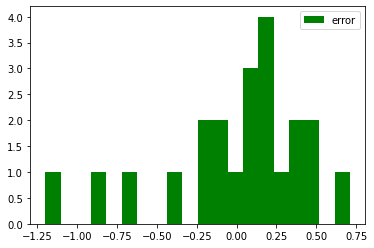

In [176]:
errors2=(predics2-T2)/T2*100
plt.hist(errors2[:,0], 20, color='green')
plt.legend(['error'])
plt.show()

In [177]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=T2[:,0], y=predics2[:,0], mode='markers', marker_size=4, name='predics', marker_color='black'),secondary_y=False)
fig.add_trace(go.Scatter(x=T2[:,0], y=T2[:,0], mode='lines', line_color='red', line_width=0.2, showlegend=False),secondary_y=False)
fig.add_trace(go.Scatter(x=T2[:,0], y=errors2[:,0], mode='markers', marker_size=4, name='errors', marker_color='orange'),secondary_y=True)

fig.update_xaxes(title_text="data")

fig.update_yaxes(title_text="predics", secondary_y=False)
fig.update_yaxes(title_text="% error", range=[-2, 2], secondary_y=True, showgrid=False, tick0=-5, dtick=2)

fig.show()

## mesh

In [178]:
x_mesh, y_mesh = np.linspace(10, 120, 31), np.linspace(-20, 50, 31)
# x_mesh, y_mesh = np.arange(-1, 2, 0.1), np.arange(-1, 2, 0.1)
x_mesh, y_mesh = np.meshgrid(x_mesh, y_mesh)
x_mesh = x_mesh.flatten().reshape(31*31,1)
y_mesh = y_mesh.flatten().reshape(31*31,1)
mesh2=np.concatenate((x_mesh, y_mesh), axis=1)
x_mesh[:5]

array([[10.        ],
       [13.66666667],
       [17.33333333],
       [21.        ],
       [24.66666667]])

In [179]:
mesh_predics2=scaler_T2.inverse_transform(  bp2.run( scaler_X2.transform(mesh2) )  )

## surface exponent excel

In [180]:
def make_xy_grid(A, B, C, D, n=2, m=2):
  n=n # horizontal dots number. min -- 2
  m=m # vertical dots number. min --2
  x=np.linspace(0,1,n)
  y=np.linspace(0,1,m)
  x,y = np.meshgrid(x,y)

  x[0][0], y[0][0]=A[0], A[1]
  x[0][n-1], y[0][n-1]=B[0], B[1]
  x[m-1][0], y[m-1][0]=C[0], C[1]
  x[m-1][n-1], y[m-1][n-1]=D[0], D[1]
  # print (x)
  # print (y)
  # vertical boundary interpol.
  for i in range(1, m-1):
    x[i][0]=x[0][0]+(x[m-1][0]-x[0][0])/m*i
    x[i][n-1]=x[0][n-1]+(x[m-1][n-1]-x[0][n-1])/m*i
    y[i][0]=y[0][0]+(y[m-1][0]-y[0][0])/m*i
    y[i][n-1]=y[0][n-1]+(y[m-1][n-1]-y[0][n-1])/m*i
  # print (x)
  # print (y)
  # horizontal inner interpol.
  for i in range(m):
    for j in range(1, n-1):
      x[i][j]=x[i][0]+(x[i][n-1]-x[i][0])/n*j
      y[i][j]=y[i][0]+(y[i][n-1]-y[i][0])/n*j
  # print (x)
  # print (y)
  return x,y

In [181]:
A=[100,0]
B=[94,32]
C=[28.9,24.5]
D=[59.2,29.5]
x45,y45=make_xy_grid(A,B,C,D,8,8)
z45=x45*14.18+y45*(-13.84)+581.1

In [182]:
x45

array([[100.       ,  99.25     ,  98.5      ,  97.75     ,  97.       ,
         96.25     ,  95.5      ,  94.       ],
       [ 91.1125   ,  90.9296875,  90.746875 ,  90.5640625,  90.38125  ,
         90.1984375,  90.015625 ,  89.65     ],
       [ 82.225    ,  82.609375 ,  82.99375  ,  83.378125 ,  83.7625   ,
         84.146875 ,  84.53125  ,  85.3      ],
       [ 73.3375   ,  74.2890625,  75.240625 ,  76.1921875,  77.14375  ,
         78.0953125,  79.046875 ,  80.95     ],
       [ 64.45     ,  65.96875  ,  67.4875   ,  69.00625  ,  70.525    ,
         72.04375  ,  73.5625   ,  76.6      ],
       [ 55.5625   ,  57.6484375,  59.734375 ,  61.8203125,  63.90625  ,
         65.9921875,  68.078125 ,  72.25     ],
       [ 46.675    ,  49.328125 ,  51.98125  ,  54.634375 ,  57.2875   ,
         59.940625 ,  62.59375  ,  67.9      ],
       [ 28.9      ,  32.6875   ,  36.475    ,  40.2625   ,  44.05     ,
         47.8375   ,  51.625    ,  59.2      ]])

In [183]:
den45=60.7073*z45**(-0.7507)+1
MKP_45C_density_exponent=go.Surface(
    contours = {
        "z": {"show": True, "start": 1.1, "end": 1.5, "size": .025, 'color':'grey'}
    },
    x = x45, y = y45, z = den45, 
    connectgaps=False,
    opacity=0.3,
    name='45C density surface',
    showlegend=True,
    # showscale=False,
    colorbar=dict(
            title='צפיפות', # title here
            titleside='right',
            len=0.5),
    colorscale='Rainbow',
    cmin=1.1, cmax=1.5,
)

## surface sigmoids

In [184]:
x45.shape

(8, 8)

In [185]:
x_mesh_sigm = x45.flatten().reshape(8*8,1)
y_mesh_sigm = y45.flatten().reshape(8*8,1)
mesh_sigm=np.concatenate((x_mesh_sigm, y_mesh_sigm), axis=1)
x_mesh_sigm[:5]

array([[100.  ],
       [ 99.25],
       [ 98.5 ],
       [ 97.75],
       [ 97.  ]])

In [186]:
MKP_45C_density_sigmoid=scaler_T2.inverse_transform(  bp2.run( scaler_X2.transform(mesh_sigm) )  )
MKP_45C_density_sigmoid.reshape(8,8)

array([[1.20874973, 1.21346436, 1.21872692, 1.22443014, 1.23042168,
        1.23652459, 1.24256558, 1.25394282],
       [1.21622396, 1.22090968, 1.22597313, 1.23131294, 1.23680378,
        1.24231096, 1.24770749, 1.25778461],
       [1.22752414, 1.23179962, 1.23628789, 1.24090421, 1.24555374,
        1.25014056, 1.25457686, 1.26273032],
       [1.24489709, 1.24799354, 1.25118749, 1.25441716, 1.25761827,
        1.2607287 , 1.26369295, 1.26901292],
       [1.27116819, 1.27177828, 1.27249465, 1.27327657, 1.2740837 ,
        1.27487821, 1.27562653, 1.27687926],
       [1.30857211, 1.30504722, 1.30177785, 1.29874821, 1.29594075,
        1.29333709, 1.2909189 , 1.28656955],
       [1.35633027, 1.34761955, 1.33922626, 1.33121585, 1.32364107,
        1.31654115, 1.30994186, 1.2982857 ],
       [1.45744103, 1.44262074, 1.42664672, 1.40984914, 1.39263252,
        1.3754406 , 1.35871345, 1.32815164]])

In [187]:
MKP_45C_density_sigmoids=go.Surface(
    contours = {
        "z": {"show": True, "start": 1.1, "end": 1.5, "size": .025, 'color':'grey'}
    },
    x = x45, y = y45, z = MKP_45C_density_sigmoid.reshape(8,8), 
    connectgaps=False,
    opacity=0.3,
    name='45C density surface sigmoids',
    showlegend=True,
    # showscale=False,
    colorbar=dict(
            title='צפיפות', # title here
            titleside='right',
            len=0.5),
    colorscale='Rainbow',
    cmin=1.1, cmax=1.5,
)

## plot

In [188]:
fig_predic=go.Figure()
fig_predic.add_trace(go.Scatter3d(x=data2[:,0], y=data2[:,1], z=data2[:,3], mode='markers', marker_size=6, name='data'))
fig_predic.add_trace(go.Scatter3d(x=data2[:,0], y=data2[:,1], z=predics2[:,0], mode='markers', marker_size=6, name='predics'))
fig_predic.add_trace(go.Scatter3d(x=x_mesh[:,0], y=y_mesh[:,0], z=mesh_predics2[:,0], mode='markers', marker_size=2, name='mesh-predics', visible='legendonly'))
# fig_predic.add_trace(MKP_45C_density_exponent)
fig_predic.add_trace(MKP_45C_density_sigmoids)

x = np.linspace(-14,120, 456)
y = np.linspace(-20,107, 484)
x, y = np.meshgrid(x,y)
image = sio.imread ("https://vladgap.github.io/MKP-web/MKP%20diag%20pic_red.jpg") 
# print(image.shape)
img = image[:,:, 1] 
Z = 0 * np.ones(x.shape)+1.101
# fig_predic.add_surface(x=x, y=y, z=Z, 
#                 surfacecolor=np.flipud(img), 
#                 colorscale='gray', 
#                 showscale=False,
#                 hoverinfo='none',
#                )

fig_predic.update_layout(
    scene = {
        "xaxis": {"range":[0,100], "nticks": 20},
        "yaxis": {"range":[0,100], "nticks": 20},
        "zaxis": {"range":[1.1,1.5], "nticks": 6},
        'xaxis_title': 'R(K)',
        'yaxis_title': 'R(SO4)',
        'zaxis_title': 'צפיפות',
        'camera_eye': {"x": 1.5, "y": -1.5, "z": .7},
        "aspectratio": {"x": 1, "y": 1, "z": 0.6},
        'camera_center': {"x": 0, "y": 0, "z": -0.01}
    },
    width=1000, height=1000,
    margin=dict(l=30, r=30, b=30, t=30),
    title_text='צפיפות תמיסת אם ב-45 מעלות',
    title_x=0.5,
)
fig_predic.update_scenes(camera_projection_type="orthographic")
# fig_predic.write_html("Na,K..H2PO4,SO4 density ortho 170522.html")

fig_predic.show()

In [189]:
bp2.print_weights()

Layers (input, hidden, output):  [2, 2, 1] sigmoid linear
Hidden layer weights:  [[1.5034804871808578, 0.03551232897431893], [-0.15121908487533917, 0.5606629421212576]]
Hidden layer biases:  [[1.510200700696482, 0.41341888240448166]]
Outlet layer weights:  [[-4.030693671600399], [0.8879135898852777]]
Outlet layer biases:  [[2.402298178126899]]


In [190]:
print_scaler_data(scaler_data2)

scaler X -- mean, stdev:   [66.50454545 22.18181818] [24.11980471  7.95410908]
scaler T -- mean, stdev:   [1.3155] [0.07992198]


# f(x1,x2) - Partial pressure(C,T)

In [191]:
data3=[
[0,	5,	10,	15,	20,	25,	30,	35,	40,	45,	50,	55,	60,	65,	70,	75,	80,	85,	90,	95,	100,	0,	5,	10,	15,	20,	25,	30,	35,	40,	45,	50,	55,	60,	65,	70,	75,	80,	85,	90,	95,	100,	0,	5,	10,	15,	20,	25,	30,	35,	40,	45,	50,	55,	60,	65,	70,	75,	80,	85,	90,	95,	100,0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 65, 70, 75, 80, 85, 90, 95, 100, 75, 80, 85, 90, 95, 100, 80, 85, 90, 95, 100, ],
[20,	20,	20,	20,	20,	20,	20,	20,	20,	20,	20,	20,	20,	20,	20,	20,	20,	20,	20,	20,	20,	30,	30,	30,	30,	30,	30,	30,	30,	30,	30,	30,	30,	30,	30,	30,	30,	30,	30,	30,	30,	30,	40,	40,	40,	40,	40,	40,	40,	40,	40,	40,	40,	40,	40,	40,	40,	40,	40,	40,	40,	40,	40,50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 130, 130, 130, 130, 130, 130, 130, 130, 140, 140, 140, 140, 140, 140, 150, 150, 150, 150, 150, ],
[23.158,	23.026,	22.763,	22.632,	22.368,	22.105,	21.447,	20.658,	19.474,	18.289,	17.105,	15.526,	13.684,	11.842,	9.737,	7.434,	5.066,	2.842,	1.184,	0.338,	0.038,	41.842,	41.447,	40.789,	39.737,	39.474,	39.211,	38.026,	36.711,	34.474,	32.632,	30.395,	27.5,	24.211,	20.921,	17.237,	13.158,	9.079,	5.197,	2.25,	0.683,	0.078,	72.763,	71.711,	71.316,	70.921,	69.737,	68.421,	66.447,	64.079,	60.658,	56.974,	53.026,	47.368,	42.237,	35.526,	29.605,	23.026,	15.921,	9.145,	4.211,	1.342,	0.158,121.842, 118.421, 115.789, 114.474, 113.158, 110.526, 107.895, 103.947, 98.684, 92.5, 86.579, 77.237, 68.421, 57.895, 48.026, 37.895, 26.184, 15.395, 7.368, 2.447, 0.301, 197.368, 193.421, 192.105, 188.158, 185.526, 184.211, 178.947, 171.053, 161.842, 152.632, 142.105, 126.316, 110.921, 93.421, 78.026, 61.842, 42.895, 25.921, 12.763, 4.382, 0.566, 307.895, 302.632, 300, 296.053, 289.474, 286.842, 277.632, 268.421, 253.947, 239.474, 223.684, 197.368, 175, 146.053, 121.053, 97.368, 68.421, 41.711, 21.316, 7.566, 1.02, 467.105, 463.158, 460.526, 453.947, 448.684, 444.737, 430.263, 409.211, 385.526, 361.842, 338.158, 298.684, 263.158, 221.053, 184.211, 146.053, 102.632, 64.211, 34.211, 12.671, 1.75, 692.105, 686.842, 682.895, 673.684, 665.789, 660.526, 638.158, 615.789, 589.474, 553.947, 517.105, 473.684, 415.789, 348.684, 293.421, 219.737, 157.895, 99.342, 53.947, 20.658, 3, 1000, 993.421, 990.789, 977.632, 967.105, 959.211, 927.632, 901.316, 863.158, 810.526, 756.579, 686.842, 605.263, 510.526, 423.684, 315.789, 227.632, 146.053, 81.579, 32.763, 4.803, 1414.474, 1405.263, 1402.632, 1384.211, 1368.421, 1356.579, 1310.526, 1276.316, 1221.053, 1147.368, 1071.053, 961.842, 817.105, 689.474, 572.368, 447.368, 322.368, 210.526, 122.368, 50.658, 7.632, 1325, 1118.421, 953.947, 797.368, 631.579, 453.947, 300, 178.947, 76.842, 11.842, 1315.789, 1098.684, 868.421, 631.579, 423.684, 259.211, 114.079, 17.237, 1177.632, 861.842, 585.526, 364.474, 165.789, 26.711, 1157.895, 789.474, 503.947, 243.421, 38.816, ]
]
#[C]
#[T]
#[P]
data3=np.array(data3).T

In [192]:
X3=data3[:,[0,1]]
T3=data3[:,[2]]

## scaling

In [193]:
scaler_X3 = preprocessing.StandardScaler().fit(X3)
scaler_T3 = preprocessing.StandardScaler().fit(T3)

# scaler_X3.mean_, scaler_X3.scale_ = 0, 1 # disable scaling
# scaler_T3.mean_, scaler_T3.scale_ = 0, 1 # disable scaling

scaler_data3 = [scaler_X3.mean_, scaler_X3.scale_, scaler_T3.mean_, scaler_T3.scale_]
print('scaler X -- mean, stdev:  ',scaler_data3[0], scaler_data3[1])
print('scaler T -- mean, stdev:  ',scaler_data3[2], scaler_data3[3])

X_sc3 = scaler_X3.transform(X3)
T_sc3 = scaler_T3.transform(T3)
X_sc3[0:3]

scaler X -- mean, stdev:   [54.0167364  73.13807531] [30.67537774 34.91450667]
scaler T -- mean, stdev:   [305.48522594] [375.99549062]


array([[-1.76091512, -1.52194834],
       [-1.59791794, -1.52194834],
       [-1.43492076, -1.52194834]])

## parameter searching

In [194]:
bp_iter=VectorBackProp(layers=[2,4,1], hidden_activation = 'sigmoid')
learning_rate = [0.001, 0.005, 0.01, 0.05]
momentum_term = [0.7, 0.8, 0.9]
learning_rate_decay = [0, 1]
repeats = range(10)
rows=len(learning_rate) * len(momentum_term) * len(learning_rate_decay) * len(repeats)
print ('total runs:', rows)
output = np.zeros((rows,5))
i=0
weights_list = []
for lr in learning_rate:
    for mt in momentum_term:
        for lrd in learning_rate_decay:
            for rep in repeats:
                bp_iter.fit(X_sc3, T_sc3, epochs=1000, learning_rate = lr, momentum_term = mt, learning_rate_decay = lrd, repeat=False)
                relative_delta=[(a-b)/a*100 for a,b in zip(bp_iter.loss_list,[0]+bp_iter.loss_list[:-1])]
                output[i] = [lr, mt, lrd, bp_iter.loss_list[-1], relative_delta[-1]]
                weights_list.append(bp_iter.export_weights())
                print (i, end=' ')
                if i%25==0 and i>0:
                    print ('\n')
                i+=1


total runs: 240
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 

26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 

51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 

76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 

126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 

151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 

176 177 178 179 

/usr/local/lib/python3.7/dist-packages/MLNN/MLNN.py:362: RuntimeWarning:

overflow encountered in exp

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:48: RuntimeWarning:

overflow encountered in reduce

/usr/local/lib/python3.7/dist-packages/MLNN/MLNN.py:418: RuntimeWarning:

overflow encountered in square

/usr/local/lib/python3.7/dist-packages/MLNN/MLNN.py:445: RuntimeWarning:

overflow encountered in matmul

/usr/local/lib/python3.7/dist-packages/MLNN/MLNN.py:445: RuntimeWarning:

invalid value encountered in multiply

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning:

invalid value encountered in double_scalars



180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 

201 202 203 204 205 

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning:

overflow encountered in reduce



206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 

226 227 228 229 230 231 232 233 234 235 236 237 238 239 

In [195]:
output_table = pd.DataFrame(data=output, columns=['learning_rate', 'momentum_term', 'learning_rate_decay', 'final_loss', 'relative_delta'])
output_table.fillna(value = 1.1, inplace = True)
output_table.head()

learning_rate  momentum_term  learning_rate_decay  final_loss  \
0          0.001            0.7                  0.0    0.181558   
1          0.001            0.7                  0.0    0.181689   
2          0.001            0.7                  0.0    0.050260   
3          0.001            0.7                  0.0    0.171548   
4          0.001            0.7                  0.0    0.181605   

   relative_delta  
0       -0.000072  
1       -0.000057  
2       -0.049515  
3       -0.066528  
4       -0.000082

In [196]:
output_table.sort_values('final_loss').head()

learning_rate  momentum_term  learning_rate_decay  final_loss  \
107          0.005            0.9                  0.0    0.007503   
100          0.005            0.9                  0.0    0.008885   
66           0.005            0.7                  0.0    0.011333   
103          0.005            0.9                  0.0    0.014667   
102          0.005            0.9                  0.0    0.016098   

     relative_delta  
107       -0.053089  
100       -0.099297  
66        -0.220437  
103       -0.053045  
102       -0.130341

In [197]:
weights_list[101]

[[[3.016111296057902,
   1.6425124399647153,
   1.7344769468937444,
   -3.646216687588722],
  [1.2071763445027532,
   1.2374121538182061,
   -2.711649225552646,
   1.0008703175970157]],
 [[1.8461970595112218,
   -6.6375274276969645,
   4.047318886383377,
   1.043582874123798]],
 [[1.8600384871320799],
  [-5.4698144686785835],
  [-4.278874606745879],
  [1.7378530125184932]],
 [[1.928230370637375]]]

In [198]:
fig = go.Figure(data=
    go.Parcoords(

        dimensions = list([
            dict(
                label = 'learning_rate', values = output_table['learning_rate']),
            dict(
                label = 'momentum_term', values = output_table['momentum_term']),
            dict(range = [0, 1],
                label = 'learning_rate_decay', values = output_table['learning_rate_decay']),
            dict(range = [0, 0.2],
                label = 'final_loss', values = output_table['final_loss']),
            dict(
                label = 'relative_delta', values = output_table['relative_delta']),
        ])
    )
)

fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white'
)

fig.show()

## running best parameters

In [199]:
bp_iter2=VectorBackProp(layers=[2,4,1], hidden_activation = 'sigmoid')
weights_lists2=[]
loss_lists2=[]
relative_delta_lists2=[]
n = 20
for i in range(n):
    bp_iter2.fit(X_sc3, T_sc3, epochs=3000, learning_rate = 0.005, momentum_term = 0.9, learning_rate_decay = 0, repeat=False)
    relative_delta=[(a-b)/a*100 for a,b in zip(bp_iter2.loss_list,[0]+bp_iter.loss_list[:-1])]
    weights_lists2.append(bp_iter2.export_weights())
    loss_lists2.append(bp_iter2.loss_list)
    relative_delta_lists2.append(relative_delta)

In [200]:
fig2=go.Figure()
[fig2.add_trace(go.Scatter(y=loss_lists2[i][100:], name=i)) for i in range(n)]
fig2.update_layout (yaxis_range=[0,0.02])
fig2.show()

In [201]:
fig2=go.Figure()
[fig2.add_trace(go.Scatter(y=relative_delta_lists2[i][100:], name=i)) for i in range(n)]
fig2.update_layout (yaxis_range=[-0.5, 0.5], title='Relative delta')
fig2.show()

## best_weights_for_now

In [202]:
best_weights_for_now3=weights_lists2[19]
best_weights_for_now3

[[[5.887808927217492,
   -2.3224461118835347,
   2.3750382680281947,
   -2.113933190396758],
  [-4.046407973377648,
   3.281397013412693,
   -0.4098343248231756,
   -0.08403876514937599]],
 [[3.4746130298209996,
   -5.366510976833542,
   -0.1930820123534446,
   -0.6279342807764516]],
 [[-0.7040682911978823],
  [3.6477813034849995],
  [-5.534229969718263],
  [-6.0713596002897665]],
 [[5.378274310759877]]]

In [203]:
manual_best_weights_for_now3=[[[0.823346203392654,
   -2.585372703897094,
   1.7081601794777435,
   2.6181769832418573],
  [-2.23955096147628,
   -0.36366754869557927,
   2.2442674271536402,
   -0.8426118192031995]],
 [[3.3467976041271066,
   -1.8467725891491473,
   -6.490382333576185,
   0.3961700785714912]],
 [[-6.0731476856592055],
  [-1.6844139337137223],
  [-4.715033206714522],
  [-1.7169339753371398]],
 [[7.0017467515267215]]]
 # epochs=3000, learning_rate = 0.005, momentum_term = 0.9, learning_rate_decay = 0
 # loss = 0.00759

## fitting best parameters

In [204]:
bp3=VectorBackProp(layers=[2,4,1], hidden_activation = 'sigmoid')

In [205]:
# bp3.import_weights(best_weights_for_now3)
bp3.import_weights(manual_best_weights_for_now3)
bp3.fit(X_sc3, T_sc3, epochs=10000, learning_rate = 0.03, momentum_term = 0.95, learning_rate_decay = 1, repeat=True)

In [206]:
fig1=go.Figure()
fig1.add_trace(go.Scatter(y=bp3.loss_list[20:], name=''))
print('Initial loss =', bp3.loss_list[0])
print('Final loss =', bp3.loss_list[-1])
fig1.show()

Initial loss = 0.007594885219419072
Final loss = 0.007359246639785838


## prediction

In [207]:
predics3=scaler_T3.inverse_transform(bp3.run(X_sc3))
# predics3

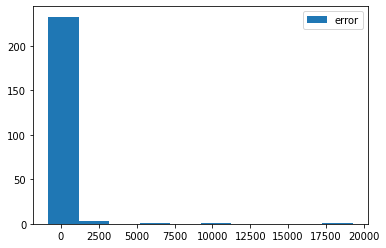

In [208]:
errors3=(predics3-T3)/T3*100
plt.hist(errors3[:,0])
plt.legend(['error'])
plt.show()

In [209]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=T3[:,0], y=predics3[:,0], mode='markers', marker_size=4, name='predics', marker_color='black'),secondary_y=False)
fig.add_trace(go.Scatter(x=T3[:,0], y=T3[:,0], mode='lines', line_color='red', line_width=0.2, showlegend=False),secondary_y=False)
fig.add_trace(go.Scatter(x=T3[:,0], y=errors3[:,0], mode='markers', marker_size=4, name='errors', marker_color='orange'),secondary_y=True)

fig.update_xaxes(title_text="data")

fig.update_yaxes(title_text="predics", secondary_y=False)
fig.update_yaxes(title_text="% error", range=[-10, 10], secondary_y=True, showgrid=False, tick0=-5, dtick=2)

fig.show()

## mesh

In [210]:
x_mesh, y_mesh = np.linspace(0, 100, 31), np.linspace(20, 150, 31)
# x_mesh, y_mesh = np.arange(-1, 2, 0.1), np.arange(-1, 2, 0.1)
x_mesh, y_mesh = np.meshgrid(x_mesh, y_mesh)
x_mesh = x_mesh.flatten().reshape(31*31,1)
y_mesh = y_mesh.flatten().reshape(31*31,1)
mesh3=np.concatenate((x_mesh, y_mesh), axis=1)
x_mesh[:5]

array([[ 0.        ],
       [ 3.33333333],
       [ 6.66666667],
       [10.        ],
       [13.33333333]])

In [211]:
mesh_predics3=scaler_T3.inverse_transform(  bp3.run( scaler_X3.transform(mesh3) )  )

## plot

In [212]:
fig_predic=go.Figure()
fig_predic.add_trace(go.Scatter3d(x=data3[:,0], y=data3[:,1], z=data3[:,2], mode='markers', marker_size=6, name='data'))
fig_predic.add_trace(go.Scatter3d(x=data3[:,0], y=data3[:,1], z=predics3[:,0], mode='markers', marker_size=6, name='predics'))
fig_predic.add_trace(go.Scatter3d(x=x_mesh[:,0], y=y_mesh[:,0], z=mesh_predics3[:,0], mode='markers', marker_size=2, name='mesh-predics', visible='legendonly'))

fig_predic.update_layout(
    scene = {
        "xaxis": {"range":[0,100], "nticks": 20},
        "yaxis": {"range":[20,150], "nticks": 20},
        # "zaxis": {"range":[1.1,1.5], "nticks": 6},
        'xaxis_title': '%H3PO4',
        'yaxis_title': 'Temperature, C',
        'zaxis_title': 'Pressure, mbar',
        'camera_eye': {"x": 1.5, "y": -1.5, "z": .7},
        "aspectratio": {"x": 1, "y": 1, "z": 0.6},
        'camera_center': {"x": 0, "y": 0, "z": -0.01}
    },
    width=1000, height=1000,
    margin=dict(l=30, r=30, b=30, t=30),
    title_text=' ',
    title_x=0.5,
)
fig_predic.update_scenes(camera_projection_type="orthographic")
# fig_predic.write_html("Na,K..H2PO4,SO4 density ortho 170522.html")

fig_predic.show()

In [213]:
bp3.print_weights()

Layers (input, hidden, output):  [2, 4, 1] sigmoid linear
Hidden layer weights:  [[0.8072846282920318, -2.5294820162557032, 1.6353084608789474, 2.548967112384343], [-2.227832973304566, -0.2852300972735733, 2.218128334876839, -0.8321259264011608]]
Hidden layer biases:  [[3.357216785926393, -1.817122738265093, -6.368237983036173, 0.46260097605455747]]
Outlet layer weights:  [[-6.206773164108749], [-1.795114906436459], [-4.874143431009051], [-1.8255413731287127]]
Outlet layer biases:  [[7.243595471079232]]


In [214]:
print_scaler_data(scaler_data3)

scaler X -- mean, stdev:   [54.0167364  73.13807531] [30.67537774 34.91450667]
scaler T -- mean, stdev:   [305.48522594] [375.99549062]


# f(x1,x2,x3)

## data

In [215]:
data5=pd.DataFrame([[3.5432, 44.1176470588235, 39.7307914468193, 1.7787,
        17.1987641606591, 1.03129605623734, 'exp1'],
       [3.5432, 44.1176470588235, 46.7421075844933, 1.61172,
        14.2121524201854, 1.33418381984987, 'exp1'],
       [3.5432, 44.1176470588235, 53.7534237221673, 1.43143,
        11.6947472745292, 1.78559851572739, 'exp1'],
       [3.5432, 44.1176470588235, 60.7647398598413, 1.3224,
        9.75359342915811, 1.8067259420946, 'exp1'],
       [3.61182, 52.5, 33.2044509861419, 1.73556, 26.109391124871,
        1.2784366054216, 'exp2'],
       [3.61182, 52.5, 39.0640599836963, 1.50787, 23.0448383733055,
        1.30063890921072, 'exp2'],
       [3.61182, 52.5, 44.9236689812508, 1.28216, 18.3303085299456,
        1.6396367983226, 'exp2'],
       [3.61182, 52.5, 50.7832779788052, 1.15506, 15.3439153439153,
        1.6793895639359, 'exp2'],
       [3.546, 41.9753086419753, 48.1611135844767, 1.548,
        13.5922330097087, 1.58024190679573, 'exp4'],
       [3.546, 41.9753086419753, 48.1611135844767, 1.548,
        13.5922330097087, 1.58024190679573, 'exp4'],
       [3.546, 41.9753086419753, 55.3852806221482, 1.44056,
        11.2244897959184, 1.75311864093404, 'exp4'],
       [3.546, 41.9753086419753, 62.6094476598198, 1.37192,
        9.61538461538462, 2.33968055882646, 'exp4'],
       [3.15645, 37.3333333333333, 46.223478589122, 1.62281,
        13.6842105263158, 1.26494899078895, 'exp7'],
       [3.15645, 37.3333333333333, 54.3805630460259, 1.48603,
        11.340206185567, 1.53596150580697, 'exp7'],
       [3.15645, 37.3333333333333, 62.5376475029298, 1.39922,
        9.18367346938775, 2.0761800720865, 'exp7'],
       [3.15645, 37.3333333333333, 70.6947319598337, 1.3311,
        7.54716981132076, 2.46615102122547, 'exp7'],
       [3.21264, 48.4375, 35.9576897475555, 1.424, 20.0,
        0.877430345937249, 'exp8'],
       [3.21264, 48.4375, 42.3031644088888, 1.25664, 17.3469387755102,
        1.21143181315366, 'exp8'],
       [3.21264, 48.4375, 48.6486390702222, 1.1736, 14.8514851485148,
        1.51090731456155, 'exp8'],
       [3.21264, 48.4375, 54.9941137315555, 1.0787, 12.8712871287129,
        2.10993639581657, 'exp8'],
       [3.17988, 57.7039274924471, 29.8573774179341, 1.2664,
        28.2178217821782, 0.922752144650929, 'exp9'],
       [3.17988, 57.7039274924471, 35.1263263740401, 1.0569,
        24.3731193580742, 1.1326227604219, 'exp9'],
       [3.17988, 57.7039274924471, 40.3952753301461, 0.9309,
        20.4901960784314, 1.2410533380211, 'exp9'],
       [3.17988, 57.7039274924471, 45.6642242862522, 0.87596,
        18.034188034188, 1.58738143967855, 'exp9']],columns=['SO4_in', 'FA_in', 'DCP_in',	'SO4', 'FA', 'P2O5_norm',	'exp'])

In [216]:
# data5=pd.read_csv('new_dcp_data.csv')
data5.iloc[:,[0,1,2,3,4,5,6]]

SO4_in      FA_in     DCP_in      SO4         FA  P2O5_norm   exp
0   3.54320  44.117647  39.730791  1.77870  17.198764   1.031296  exp1
1   3.54320  44.117647  46.742108  1.61172  14.212152   1.334184  exp1
2   3.54320  44.117647  53.753424  1.43143  11.694747   1.785599  exp1
3   3.54320  44.117647  60.764740  1.32240   9.753593   1.806726  exp1
4   3.61182  52.500000  33.204451  1.73556  26.109391   1.278437  exp2
5   3.61182  52.500000  39.064060  1.50787  23.044838   1.300639  exp2
6   3.61182  52.500000  44.923669  1.28216  18.330309   1.639637  exp2
7   3.61182  52.500000  50.783278  1.15506  15.343915   1.679390  exp2
8   3.54600  41.975309  48.161114  1.54800  13.592233   1.580242  exp4
9   3.54600  41.975309  48.161114  1.54800  13.592233   1.580242  exp4
10  3.54600  41.975309  55.385281  1.44056  11.224490   1.753119  exp4
11  3.54600  41.975309  62.609448  1.37192   9.615385   2.339681  exp4
12  3.15645  37.333333  46.223479  1.62281  13.684211   1.264949  exp7
13  3.15645  37.333333  54.380563  1.48603  11.340206   1.535962  exp7
14  3.15645  37.333333  62.537648  1.39922   9.183673   2.076180  exp7
15  3.15645  37.333333  70.694732  1.33110   7.547170   2.466151  exp7
16  3.21264  48.437500  35.957690  1.42400  20.000000   0.877430  exp8
17  3.21264  48.437500  42.303164  1.25664  17.346939   1.211432  exp8
18  3.21264  48.437500  48.648639  1.17360  14.851485   1.510907  exp8
19  3.21264  48.437500  54.994114  1.07870  12.871287   2.109936  exp8
20  3.17988  57.703927  29.857377  1.26640  28.217822   0.922752  exp9
21  3.17988  57.703927  35.126326  1.05690  24.373119   1.132623  exp9
22  3.17988  57.703927  40.395275  0.93090  20.490196   1.241053  exp9
23  3.17988  57.703927  45.664224  0.87596  18.034188   1.587381  exp9

In [217]:
X5=np.array(data5)[:,[0,1,2]]
T5=np.array(data5)[:,[3,4,5]]

## scaling

In [218]:
scaler_X5 = preprocessing.StandardScaler().fit(X5)
scaler_T5 = preprocessing.StandardScaler().fit(T5)

# scaler_X5.mean_, scaler_X5.scale_ = np.zeros(X5.shape[1]), np.ones(X5.shape[1]) # disable scaling
# scaler_T5.mean_, scaler_T5.scale_ = np.zeros(T5.shape[1]), np.ones(T5.shape[1]) # disable scaling

scaler_data5 = [scaler_X5.mean_, scaler_X5.scale_, scaler_T5.mean_, scaler_T5.scale_]
print('scaler X -- mean, stdev:  ',scaler_data5[0], scaler_data5[1])
print('scaler T -- mean, stdev:  ',scaler_data5[2], scaler_data5[3])

X_sc5 = scaler_X5.transform(X5)
T_sc5 = scaler_T5.transform(T5)
X_sc5[0:3]

scaler X -- mean, stdev:   [ 3.37499833 47.01128609 47.91944614] [ 0.19399856  6.75635049 10.01060258]
scaler T -- mean, stdev:   [ 1.35981833 15.90218114  1.5435811 ] [0.22990127 5.44826372 0.40863675]


array([[ 0.86702535, -0.42828433, -0.81799818],
       [ 0.86702535, -0.42828433, -0.11760916],
       [ 0.86702535, -0.42828433,  0.58277986]])

## parameter searching

In [219]:
bp_iter=VectorBackProp(layers=[3,6,3], hidden_activation = 'prelu')
learning_rate = [0.001, 0.005, 0.01]
momentum_term = [0.8, 0.9, 0.95]
learning_rate_decay = [0]
repeats = range(10)
rows=len(learning_rate) * len(momentum_term) * len(learning_rate_decay) * len(repeats)
print ('total runs:', rows)
output = np.zeros((rows,5))
i=0
weights_list = []
for lr in learning_rate:
    for mt in momentum_term:
        for lrd in learning_rate_decay:
            for rep in repeats:
                bp_iter.fit(X_sc5, T_sc5, epochs=1000, learning_rate = lr, momentum_term = mt, learning_rate_decay = lrd, repeat=False)
                output[i] = [lr, mt, lrd, bp_iter.loss_list[-1], bp_iter.loss_list[-2] - bp_iter.loss_list[-1]]
                weights_list.append(bp_iter.export_weights())
                print (i, end=' ')
                if i%25==0 and i>0:
                    print ('\n')
                i+=1

total runs: 90
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 

26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 

51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 

76 77 78 79 80 81 82 

/usr/local/lib/python3.7/dist-packages/MLNN/MLNN.py:402: RuntimeWarning:

overflow encountered in matmul

/usr/local/lib/python3.7/dist-packages/MLNN/MLNN.py:433: RuntimeWarning:

invalid value encountered in matmul

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning:

invalid value encountered in reduce

/usr/local/lib/python3.7/dist-packages/MLNN/MLNN.py:454: RuntimeWarning:

invalid value encountered in matmul



83 84 85 86 87 88 89 

In [220]:
output_table = pd.DataFrame(data=output, columns=['learning_rate', 'momentum_term', 'learning_rate_decay', 'final_loss', 'final_loss_gradient'])
output_table.fillna(value = 1.1, inplace = True)
output_table.head()

learning_rate  momentum_term  learning_rate_decay  final_loss  \
0          0.001            0.8                  0.0    0.082780   
1          0.001            0.8                  0.0    0.079280   
2          0.001            0.8                  0.0    0.079354   
3          0.001            0.8                  0.0    0.059041   
4          0.001            0.8                  0.0    0.104643   

   final_loss_gradient  
0             0.000010  
1             0.000018  
2             0.000002  
3             0.000018  
4             0.000004

In [221]:
fig = go.Figure(data=
    go.Parcoords(

        dimensions = list([
            dict(
                label = 'learning_rate', values = output_table['learning_rate']),
            dict(
                label = 'momentum_term', values = output_table['momentum_term']),
            dict(
                label = 'learning_rate_decay', values = output_table['learning_rate_decay']),
            dict(range = [0, 0.2],
                label = 'final_loss', values = output_table['final_loss']),
            dict(
                label = 'final_loss_gradient', values = output_table['final_loss_gradient']),
        ])
    )
)

fig.update_layout(
    plot_bgcolor = 'grey',
    paper_bgcolor = 'beige'
)

fig.show()

## running best parameters

In [222]:
bp_iter=VectorBackProp(layers=[3,6,3], hidden_activation = 'prelu')
weights_lists2=[]
loss_lists2=[]
relative_delta_lists2=[]
n = 20
for i in range(n):
    bp_iter.fit(X_sc5, T_sc5, epochs=1000, learning_rate = 0.01, momentum_term = 0.9, learning_rate_decay = 0., repeat=False)
    relative_delta=[(a-b)/a*100 for a,b in zip(bp_iter.loss_list,[0]+bp_iter.loss_list[:-1])]
    weights_lists2.append(bp_iter.export_weights())
    loss_lists2.append(bp_iter.loss_list)
    relative_delta_lists2.append(relative_delta)

In [223]:
fig2=go.Figure()
[fig2.add_trace(go.Scatter(y=loss_lists2[i][100:], name=i)) for i in range(n)]
fig2.update_layout (yaxis_range=[0,0.1])
fig2.show()

## best_weights_for_now

In [224]:
best_weights_for_now5=weights_lists2[11]
best_weights_for_now5

[[[-0.02414404834286132,
   0.5617094560285472,
   0.19375781076955811,
   -0.6140933042567325,
   -0.6177450044590567,
   -0.3361879588106259],
  [0.029666688413823517,
   0.38096946004318666,
   -0.10365126436211805,
   0.717995357913095,
   1.3901765944314781,
   0.6445112548139202],
  [0.022235153183154218,
   -0.9515024594559235,
   1.5189280190140177,
   0.29566847017839276,
   -0.33266993888948854,
   -1.647744515186315]],
 [[-0.10740304639255686,
   -0.8112481507503577,
   -0.5884666278873241,
   0.25455530051850445,
   1.111419539298949,
   0.8491607693828216]],
 [[-0.05448779040809156, -0.04256268775514975, -0.03981235317553164],
  [0.7257843217624227, 0.6699148470856325, 0.8500849076100773],
  [-0.42789972644806673, -0.32451241385318935, 0.812762995172968],
  [0.6155644958248484, -0.26355221742749374, -0.04280096011155756],
  [-1.5511054561461508, 0.17434586400398777, 0.7016574220797107],
  [0.8293568424497515, 0.3299118570099144, -1.02565182845552]],
 [[0.6820590654170955, 

In [225]:
manual_best_weights_for_now5=[[[0.8535201744981578,
   0.23891613325375433,
   -0.3706213592894098,
   -0.4319215564257858,
   0.5806683166099315,
   -0.45312440005788335],
  [-1.3954718784061861,
   -0.695150962232366,
   1.1092111487917213,
   0.5088073751345356,
   0.5475099337474189,
   0.9996855926675174],
  [0.2864841341539176,
   -0.9760182043221927,
   0.13147906109812887,
   1.176281755284305,
   -0.8627091456740976,
   -0.9969945042729156]],
 [[-1.7087073195023568,
   0.23484366855236094,
   0.904933268468465,
   -0.521738685225468,
   -0.7736711357904624,
   1.1694566633838352]],
 [[-0.37439150804139865, -0.12464629196196286, 2.250932496148333],
  [0.6951467932848032, 0.43765573963810295, -0.3777968880846245],
  [-1.089233486958558, 0.16654587440970814, 0.7755593752719424],
  [-0.16760703937947458, -0.34873049602012374, 1.087041365827288],
  [0.5250137257120451, 0.7309124150382786, 0.6503922051030756],
  [0.25020352808877644, 0.31343691683212843, -0.8403323706548815]],
 [[0.2889052934673156, -0.9086179498937622, 0.19248109225363927]]]

 # epochs=1000, learning_rate = 0.01, momentum_term = 0.9, learning_rate_decay = 0.
 # loss = 0.0284 

## fitting best parameters

In [226]:
bp5=VectorBackProp(layers=[3,6,3], hidden_activation = 'prelu')

In [227]:
# bp5.fit_graddescent(X_sc5, T_sc5, epochs=3000, eps=0.001, repeat=False)
# bp5.import_weights(best_weights_for_now5)
bp5.import_weights(manual_best_weights_for_now5)
bp5.fit(X_sc5, T_sc5, epochs=10000, learning_rate = 0.01, momentum_term = 0.9, learning_rate_decay = 1., repeat=True)

In [228]:
fig1=go.Figure()
fig1.add_trace(go.Scatter(y=bp5.loss_list[20:], name=''))
print('Initial loss =', bp5.loss_list[0])
print('Final loss =', bp5.loss_list[-1])
fig1.show()

Initial loss = 0.028382879846776662
Final loss = 0.028332913247589218


## prediction

In [229]:
predics5=scaler_T5.inverse_transform(bp5.run(X_sc5))
predics5

array([[ 1.76312938, 17.41844692,  1.03526098],
       [ 1.56641473, 13.88102083,  1.35765046],
       [ 1.40697973, 11.5291594 ,  1.65393958],
       [ 1.34080709, 10.44312998,  1.8861871 ],
       [ 1.72474082, 26.84907641,  1.21347743],
       [ 1.51962687, 22.5469824 ,  1.393421  ],
       [ 1.31451293, 18.24488838,  1.57336458],
       [ 1.15982684, 14.69654058,  1.70471165],
       [ 1.56858714, 13.14151085,  1.5581039 ],
       [ 1.56858714, 13.14151085,  1.5581039 ],
       [ 1.43818505, 11.31210133,  1.85873091],
       [ 1.36505542,  9.75083964,  2.28497975],
       [ 1.63012994, 14.35783935,  1.3023633 ],
       [ 1.47885926, 11.74146984,  1.56925502],
       [ 1.38857884,  9.12306897,  2.04622571],
       [ 1.34286875,  7.33095221,  2.48299508],
       [ 1.44146255, 19.68740573,  0.85095804],
       [ 1.2851706 , 17.20457264,  1.19052034],
       [ 1.15653987, 15.08936461,  1.51752065],
       [ 1.07030573, 12.66875284,  2.09249308],
       [ 1.2483389 , 27.84728955,  0.964

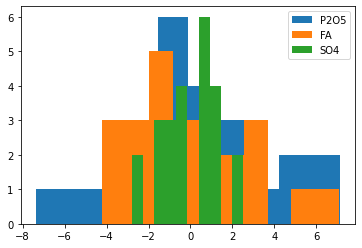

In [230]:
pred=predics5
predics5_y1_vbp=pred[:,0]
error5_y1_vbp=(predics5_y1_vbp-T5[:,0])/T5[:,0]*100
predics5_y2_vbp=pred[:,1]
error5_y2_vbp=(predics5_y2_vbp-T5[:,1])/T5[:,1]*100
predics5_y3_vbp=pred[:,2]
error5_y3_vbp=(predics5_y3_vbp-T5[:,2])/T5[:,2]*100

plt.hist(error5_y3_vbp)
plt.hist(error5_y2_vbp)
plt.hist(error5_y1_vbp)
plt.legend(['P2O5', 'FA', 'SO4'])
plt.show()

In [231]:
fig = make_subplots(rows=1, cols=3, subplot_titles=("SO4", "FA", "P2O5"), column_widths=[0.33, 0.33, 0.33],
                     specs=[[{"secondary_y": True}, {"secondary_y": True}, {"secondary_y": True}]])

fig.add_trace(go.Scatter(x=T5[:,0] , y=predics5_y1_vbp, mode='markers', marker_size=4, text=data5.exp, name='predics SO4', marker_color='black' ), 1, 1)
fig.add_trace(go.Scatter(x=T5[:,1] , y=predics5_y2_vbp, mode='markers', marker_size=4, text=data5.exp, name='predics FA', marker_color='black' ), 1, 2)
fig.add_trace(go.Scatter(x=T5[:,2] , y=predics5_y3_vbp, mode='markers', marker_size=4, text=data5.exp, name='predics P2O5', marker_color='black' ), 1, 3)

fig.add_trace(go.Scatter(x=T5[:,0] , y=error5_y1_vbp, mode='markers', marker_size=4, text=data5.exp, name='error SO4', marker_color='orange' ), 1, 1, secondary_y=True,)
fig.add_trace(go.Scatter(x=T5[:,1] , y=error5_y2_vbp, mode='markers', marker_size=4, text=data5.exp, name='error FA', marker_color='orange' ), 1, 2, secondary_y=True,)
fig.add_trace(go.Scatter(x=T5[:,2] , y=error5_y3_vbp, mode='markers', marker_size=4, text=data5.exp, name='error P2O5', marker_color='orange' ), 1, 3, secondary_y=True,)

fig.update_layout(title='', autosize=True,
                  width=1550, height=400,
                  margin=dict(l=0, r=0, b=0, t=30))

fig.update_xaxes(title_text="", range=[0.5, 2], row=1, col=1)
fig.update_yaxes(title_text="", range=[0.5, 2], row=1, col=1)
fig.update_yaxes(title_text="%error", range=[-10, 10], row=1, col=1, secondary_y=True, showgrid=False, tick0=-10, dtick=2)

fig.update_xaxes(title_text="", range=[0, 30], row=1, col=2)
fig.update_yaxes(title_text="", range=[0, 30], row=1, col=2)
fig.update_yaxes(title_text="%error", range=[-10, 10], row=1, col=2, secondary_y=True, showgrid=False, tickvals=[-10,-5,-1,0,1,5,10])

fig.update_xaxes(title_text="", range=[0.5, 2], row=1, col=3)
fig.update_yaxes(title_text="", range=[0.5, 2], row=1, col=3)
fig.update_yaxes(title_text="%error", range=[-10, 10], row=1, col=3, secondary_y=True, showgrid=False, tick0=-10, dtick=2)

fig.show()